In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.integrate import solve_ivp
from sklearn.metrics import r2_score
import sys
import torch

sys.path.append('../..')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

In [3]:
def rnn(t, x, W, tau, g):
    return (1/tau)*(-x + g*W @ np.tanh(x))

def rnn_jacobian(x, W, g, tau, dt, N, use_torch=False, device='cpu', dtype='torch.DoubleTensor'):
    x = numpy_torch_conversion(x, use_torch, device, dtype)
    W = numpy_torch_conversion(W, use_torch, device, dtype)
    if use_torch:
        I = torch.eye(N).type(dtype).to(device)
        if len(x.shape) == 1:
            return I + (dt/tau)*(-I + (g*W @ torch.diag(1 - torch.tanh(x)**2)))
        else:
            return I.unsqueeze(0) + (dt/tau)*(-I.unsqueeze(0) + (g*W*((1 - torch.tanh(x)**2).unsqueeze(1))))
    else:
        if len(x.shape) == 1:
            return np.eye(N) + (dt/tau)*(-np.eye(N) + (g*W @ np.diag(1 - np.tanh(x)**2)))
        else:
            print((1 - np.tanh(x)**2)[:, np.newaxis].shape)
            return np.eye(N)[np.newaxis] + (dt/tau)*(-np.eye(N)[np.newaxis] + (g*W*(1 - np.tanh(x)**2)[:, np.newaxis]))

def compute_lyaps(Js, dt=1, k=None, worker_num=None, message_queue=None, verbose=False):
    T, n = Js.shape[0], Js.shape[1]
    old_Q = np.eye(n)
    if k is None:
        k = n
    old_Q = old_Q[:, :k]
    lexp = np.zeros(k)
    lexp_counts = np.zeros(k)
    for t in tqdm(range(T), disable=not verbose):
        # QR-decomposition of Js[t] * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(Js[t], old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
#         print(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)
        old_Q = mat_Q
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)

#         print(diag_R)
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape, dtype="float32")
        lexp_i[idx] = np.log(diag_R[idx])
#         lexp_i[np.where(diag_R == 0)] = np.inf
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

        # it may happen that all R-matrices contained zeros => exponent really has
        # to be -inf

        # normalize exponents over number of individual mat_Rs
#         idx = np.where(lexp_counts > 0)
        #lexp[idx] /= lexp_counts[idx]
#         lexp[np.where(lexp_counts == 0)] = np.inf

        if message_queue is not None:
            message_queue.put((worker_num, "task complete", "DEBUG"))
    
    return np.divide(lexp, lexp_counts)*(1/dt)

In [6]:
chaotic_net_folder = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/chaotic_nets_multirun'

# Initial

In [5]:
chaotic_net_path = "/scratch2/weka/millerlab/eisenaj/DynamicalTrajectories/chaotic_net_data"

W = pd.read_pickle(os.path.join(chaotic_net_path, "W.pkl"))
lyaps = pd.read_pickle(os.path.join(chaotic_net_path, "lyaps_long.pkl"))
full_signals = pd.read_pickle(os.path.join(chaotic_net_path, "chaotic_net_signals_long.pkl"))

In [6]:
N = list(full_signals.values())[0].shape[2]
T = list(full_signals.values())[0].shape[1]
dt = 0.01
tau = 0.1

batch_size = 500
num_batches = int(T/batch_size)

device = 'cuda'
use_torch = True

In [7]:
# signals = {key: signal[0] for key, signal in full_signals.items()}
# ret = dict(
#     W=W,
#     lyaps=lyaps,
#     signals=signals,
#     dt=dt,
#     tau=tau,
#     N=N,
#     T=T
# )
# pd.to_pickle(ret, os.path.join(chaotic_net_folder, "RUN_ORIG"))

# Run

In [8]:
g_vals = list(full_signals.keys())

In [9]:
NUM_RUNS = 20

In [10]:
t_span = [0, 200]
t_eval = np.arange(t_span[0], t_span[1], dt)

In [11]:
for run_num in tqdm(range(NUM_RUNS)):
    if not os.path.exists(os.path.join(chaotic_net_folder, f"RUN_{run_num}")):
        print("="*40)
        print(f"RUN_NUM = {run_num}")
        print("="*40)

        signals = {}
        lyaps = {}

        np.random.seed(42 + run_num)

        print("Simulating signals...")
        W = np.random.randn(N, N)/np.sqrt(N)
        for g in tqdm(g_vals):
            x0 = np.random.randn(N)
            sol = solve_ivp(lambda t, x: rnn(t, x, W=W, tau=tau, g=g), t_span=t_span, t_eval=t_eval, y0=x0)
            signals[g] = sol.y.T
        print("Signals simulated!")

        print("MAIN ANALYSIS:")
        for key in tqdm(g_vals):
            print("-"*20)
            print(f"g = {key}")
            print("-"*20)
            signal = signals[g]
            g = key

            Js = np.zeros((signal.shape[0], N, N))
            print("Computing Jacobians..")
            for batch_num in tqdm(range(num_batches)):
                start_ind = batch_num*batch_size
                end_ind = np.min([(batch_num + 1)*batch_size, signal.shape[0]])
                batch_Js = rnn_jacobian(signal[start_ind:end_ind], W, g, tau, dt, N, use_torch=use_torch, device=device)
                if device == 'cuda':
                    batch_Js = batch_Js.cpu()
                Js[start_ind:end_ind] = batch_Js

            print("Computing Lyaps...")
            lyaps[key] = compute_lyaps(Js, dt=1, k=3, verbose=True)

        ret = dict(
            W=W,
            lyaps=lyaps,
            signals=signals,
            dt=dt,
            tau=tau,
            N=N,
            T=T
        )
        pd.to_pickle(ret, os.path.join(chaotic_net_folder, f"RUN_{run_num}"))

  0%|          | 0/20 [00:00<?, ?it/s]

RUN_NUM = 0
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 1
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 2
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 3
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 4
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 5
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 6
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 7
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 8
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 9
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 10
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 11
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 12
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 13
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 14
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 15
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 16
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 17
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 18
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

RUN_NUM = 19
Simulating signals...


  0%|          | 0/12 [00:00<?, ?it/s]

Signals simulated!
MAIN ANALYSIS:


  0%|          | 0/12 [00:00<?, ?it/s]

--------------------
g = 0.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 0.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.1
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.2
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.3
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.4
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.5
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.6
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.7
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.8
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

--------------------
g = 1.9
--------------------
Computing Jacobians..


  0%|          | 0/40 [00:00<?, ?it/s]

Computing Lyaps...


  0%|          | 0/20000 [00:00<?, ?it/s]

# Compute DeLASE

In [86]:
parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000]),
    r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000, 1200, 1400, 1600, 1800])
)

prediction_time = 4000
transient = 2000

mean_stab_curve = True
keys = np.array(list(signals.keys()))
key_inds = [i for i in range(len(keys)) if keys[i] >= 1.1]
true_vals = [lyaps[key][0] for key in keys[key_inds]]

num_indices = 50

use_torch=True
device='cuda'

noise_sd = 0.1

In [87]:
files = os.listdir(chaotic_net_folder)
files.sort(key=lambda x: int(x.split('_')[1]) if x.split('_')[1] != 'ORIG' else -1)

In [88]:
for f in files:
    if not os.path.exists(os.path.join(chaotic_net_folder, f"{f}_DeLASE")):
        print("="*40)
        print(f"{f}")
        print("="*40)

        if f == "RUN_ORIG":
            np.random.seed(41)
        else:
            np.random.seed(42 + int(f.split('_')[1]))

        run_ret = pd.read_pickle(os.path.join(chaotic_net_folder, f))

        indices = np.random.choice(np.arange(N), size=(num_indices, ), replace=False)

        full_signals = run_ret['signals']
        signals = {key: full_signal[:, indices] for key, full_signal in full_signals.items()}
        
        for key in signals.keys():
            signals[key] += np.random.randn(T, len(indices))*noise_sd

        print("Computing DeLASE...")
        results = []
        iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(parameter_grid.r_vals))
        for window in parameter_grid.window_vals:
            for matrix_size in parameter_grid.matrix_size_vals:
                delases = {}
                exp_variances = {}
        #         train_signals = []
                test_signals = {}
                for key, signal in signals.items():
                    train_signal = signal[transient:transient + window]
                    test_signal = signal[transient + window:transient + window + prediction_time]
                    delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=use_torch, device=device, dtype='torch.DoubleTensor')
                    delase.to('cpu')
                    if use_torch:
                        exp_variances[key] = delase.cumulative_explained_variance.cpu().double()
                    else:
                        exp_variances[key] = delase.cumulative_explained_variance
                    delases[key] = delase
        #             train_signals.append(train_signal)
                    test_signals[key] = test_signal
                for r in parameter_grid.r_vals:
                    if r <= np.min([delase.n*delase.p for delase in delases.values()]):
                        stab_curves = {}
                        AICs = {}
                        for key, delase in delases.items():
                            delase.to(device)
                            delase.compute_havok_dmd(r=r)
                            delase.get_stability(max_freq=500, max_unstable_freq=125)

                            AICs[key] = compute_AIC(delase, test_signals[key])
                            if use_torch:
                                stab_curves[key] = delase.stability_params.cpu()
                            else:
                                stab_curves[key] = delase.stability_params

                        if use_torch:
                            exp_variances = np.array([delase.cumulative_explained_variance[r-1].cpu().numpy() for delase in delases.values()])
                        else:
                            exp_variances = np.array([delase.cumulative_explained_variance[r-1] for delase in delases.values()])

                        results.append(dict(
                            window=window,
                            matrix_size=matrix_size,
                            r=r,
                            exp_variances=exp_variances,
                            AICs=AICs,
                            stab_curves=stab_curves,
                        ))

                    iterator.update()
        iterator.close()

        results = pd.DataFrame(results)
        results_dict = {}
        for key in signals.keys():
            ret_temp = results.copy()
            ret_temp = ret_temp.drop('AICs', axis=1)
            ret_temp = ret_temp.drop('stab_curves', axis=1)
            ret_temp = ret_temp.drop('exp_variances', axis=1)
            ret_temp['AIC'] = results.AICs.apply(lambda x: x[key])
            ret_temp['stab_curves'] = results.stab_curves.apply(lambda x: x[key])
            ret_temp = ret_temp.set_index((['window', 'matrix_size', 'r']))
            results_dict[key] = ret_temp


        pd.to_pickle(results_dict, os.path.join(chaotic_net_folder, f"{f}_DeLASE"))

RUN_ORIG
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_0
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_1
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_2
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_3
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_4
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_5
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_6
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_7
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_8
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_9
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_10
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



RUN_13
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_14
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_15
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_16
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_17
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_18
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

RUN_19
Computing DeLASE...


  0%|          | 0/308 [00:00<?, ?it/s]

# Analyze Results

In [7]:
def compute_nonnormality(A, normalized=False, return_eigvals=False):
    fro_norm = np.linalg.norm(A)**2
    eigvals = np.linalg.eigvals(A)
    eigval_sum = (np.abs(eigvals)**2).sum()
    if normalized:
        scale = 1/np.sqrt(A.shape[0])
    else:
        scale = 1
    nonnormality = np.sqrt(fro_norm - eigval_sum)*scale
    if return_eigvals:
        return nonnormality, eigvals
    else:
        return nonnormality

In [8]:
ret_files = [f for f in os.listdir(chaotic_net_folder) if 'DeLASE' not in f]
ret_files.sort()
num_indices = 50
N = 512

In [9]:
g_min = 1.1
g_max = 1.8

In [10]:
all_rets = []
for ret_file in tqdm(ret_files):
    signal_rets = pd.read_pickle(os.path.join(chaotic_net_folder, ret_file))
    all_rets.append({'lyaps': {key: signal_rets['lyaps'][key][0] for key in signal_rets['lyaps'].keys() if key >= g_min and key <= g_max}})
    delase_rets = pd.read_pickle(os.path.join(chaotic_net_folder, ret_file + '_DeLASE'))
    window, matrix_size, r, all_results = combine_grid_results({key: delase_rets[key] for key in delase_rets.keys() if key >= g_min and key <= g_max})
    all_rets[-1]['stab_curves'] = {key: delase_rets[key].loc[(window, matrix_size, r)].stab_curves for key in delase_rets.keys() if key >= g_min and key <= g_max}
    
    if ret_file == "RUN_ORIG":
        np.random.seed(41)
    else:
        np.random.seed(42 + int(ret_file.split('_')[1]))

    indices = np.random.choice(np.arange(N), size=(num_indices, ), replace=False)

    nonnormalities = {}
    for key, full_signal in signal_rets['signals'].items():
        if key >= g_min and key <= g_max:
            delase = DeLASE(full_signal[:window, indices], matrix_size=matrix_size, use_torch=True, device='cuda')
            delase.compute_havok_dmd(r=r)
            nonnormalities[key] = compute_nonnormality(delase.A.cpu(), normalized=True)
    
    all_rets[-1]['nonnormalities'] = nonnormalities

  0%|          | 0/21 [00:00<?, ?it/s]

In [24]:
top_percent = 0.1

In [25]:
g_vals = np.array(list(all_rets[0]['lyaps'].keys()))

In [26]:
k = len(all_rets[0]['lyaps'].keys())
mean_lyaps = np.zeros(k)
mean_stab = np.zeros(k)
mean_nonnorm = np.zeros(k)

counts_lyaps = np.zeros(k)
counts_stab = np.zeros(k)
counts_nonnorm = np.zeros(k)

for ret in all_rets:
    mean_lyaps += np.array([ret['lyaps'][key] for key in g_vals])
    counts_lyaps += 1
    
    mean_stab += np.array([ret['stab_curves'][key][:int(top_percent*len(ret['stab_curves'][key]))].sum() for key in g_vals])
    counts_stab += np.array([int(top_percent*len(ret['stab_curves'][key])) for key in g_vals])
    
    mean_nonnorm += np.array([ret['nonnormalities'][key] for key in g_vals])
    counts_nonnorm += 1
    
mean_lyaps /= counts_lyaps
mean_stab /= counts_stab
mean_nonnorm /= counts_nonnorm

In [27]:
k = len(all_rets[0]['lyaps'].keys())
se_lyaps = np.zeros(k)
se_stab = np.zeros(k)
se_nonnorm = np.zeros(k)

for ret in all_rets:
    se_lyaps += (np.array([ret['lyaps'][key] for key in g_vals]) - mean_lyaps)**2
    
    se_stab +=  np.array([((ret['stab_curves'][key][:int(top_percent*len(ret['stab_curves'][key]))] - mean_stab[np.where(g_vals == key)[0]])**2).sum() for key in g_vals])
    
    se_nonnorm += (np.array([ret['nonnormalities'][key] for key in g_vals]) - mean_nonnorm)**2

se_lyaps /= counts_lyaps
se_lyaps = np.sqrt(se_lyaps)
se_lyaps /= np.sqrt(counts_lyaps)

se_stab /= counts_stab
se_stab = np.sqrt(se_stab)
se_stab /= np.sqrt(counts_stab)

se_nonnorm /= counts_nonnorm
se_nonnorm = np.sqrt(se_nonnorm)
se_nonnorm /= np.sqrt(counts_nonnorm)

In [28]:
scipy.stats.pearsonr(mean_stab, mean_lyaps)

(0.979677359409485, 2.066508831485664e-05)

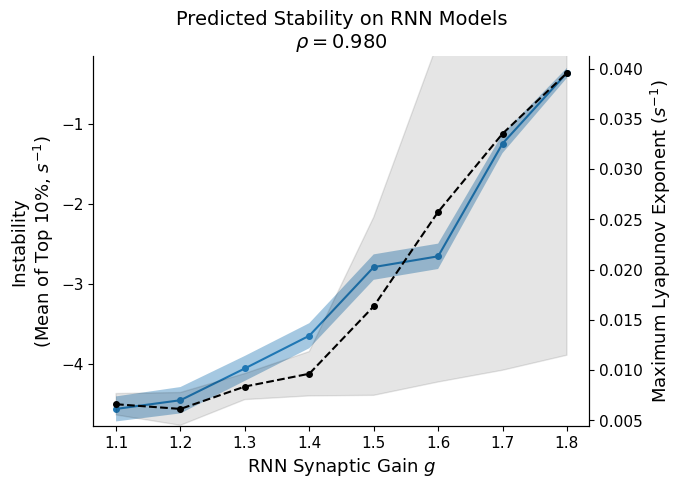

In [54]:
tick_fontsize = 11
ylabel_fontsize = 13
xlabel_fontsize = 13
title_fontsize = 14

ax = plt.gca()
ax.plot(g_vals, mean_stab, marker='o', markersize=4)
ylim = ax.get_ylim()
ax.fill_between(g_vals, mean_stab - se_stab, mean_stab + se_stab, alpha=0.4)
ax.set_ylim(ylim)
ax2 = ax.twinx()
ax2.plot(g_vals, mean_lyaps, c='k', linestyle='--', marker='o', markersize=4)
ylim = ax2.get_ylim()
ax2.fill_between(g_vals, mean_lyaps - se_lyaps, mean_lyaps + se_lyaps, color='k', alpha = 0.1)
ax2.set_ylim(ylim)

ax.tick_params(labelsize=tick_fontsize)
ax.set_ylabel('Instability\n(Mean of Top 10%, $s^{-1}$)', fontsize=ylabel_fontsize)
ax.set_xlabel('RNN Synaptic Gain $g$', fontsize=xlabel_fontsize)

ax.set_title("Predicted Stability on RNN Models\n" + fr"$\rho = ${scipy.stats.pearsonr(mean_stab, mean_lyaps)[0]:.3f}", fontsize=title_fontsize)

ax2.tick_params(labelsize=tick_fontsize)
ax2.set_ylabel('Maximum Lyapunov Exponent ($s^{-1}$)', fontsize=ylabel_fontsize)

ax.spines[['top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax2.spines[['top']].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('right')

plt.show()

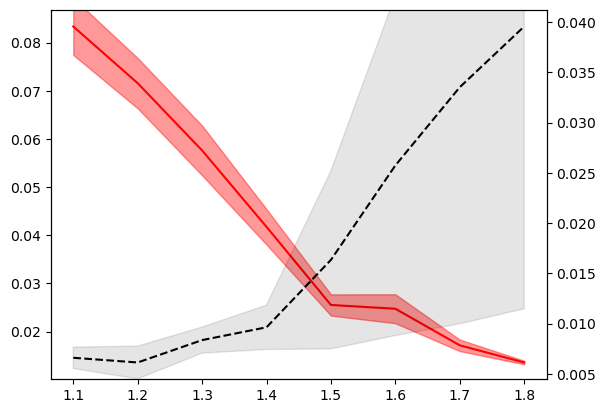

In [130]:
ax = plt.gca()
ax.plot(g_vals, mean_nonnorm, c='r')
ylim = ax.get_ylim()
ax.fill_between(g_vals, mean_nonnorm - se_nonnorm, mean_nonnorm + se_nonnorm, alpha=0.4, color='r')
ax.set_ylim(ylim)
ax2 = ax.twinx()
ax2.plot(g_vals, mean_lyaps, c='k', linestyle='--')
ylim = ax2.get_ylim()
ax2.fill_between(g_vals, mean_lyaps - se_lyaps, mean_lyaps + se_lyaps, color='k', alpha = 0.1)
ax2.set_ylim(ylim)
plt.show()

In [120]:
scipy.stats.pearsonr(mean_nonnorm, mean_lyaps)

(-0.862007361537865, 0.00590802343668723)